# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [12,8] # bigger figures

In [3]:
# import package
# installed via pip
from emtracks.particle import trajectory_solver # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function

In [4]:
datadir = "/home/shared_data/"
plotdir = datadir+"plots/randomphi/"
mapdir = datadir+"Bmaps/"

In [5]:
B_Mu2e_func = get_df_interp_func(mapdir+"Mu2e_DSMap_V13.p", gauss=False)

# Functions

In [6]:
def get_random_phi(N):   #change left boundary to math.pi work with those values later - if it works in some cases, stick with the stuff that works then go back
    # calls np.random, returns np.array with N randomized phi values
    phis = np.random.uniform(0, 2*math.pi, N) # uniform distribution between 0 and 2pi
    return phis

In [7]:
def run_solver(phi, N_calc, field, xnaught, ynaught, znaught):
    ic_Mu2e = InitConds(t0=0., tf=4e-8, N_t=N_calc,
                    x0=xnaught, y0=ynaught, z0=znaught,
                    p0=104.96, theta0=np.pi/3, phi0=phi)
    e_solver = trajectory_solver(ic_Mu2e, B_func=field, bounds=bounds_Mu2e)
    sol = e_solver.solve_trajectory(verbose = False, atol=1e-8, rtol=1e-8) # high tolerance so it runs quickly for testing
    df = e_solver.dataframe
    df['r'] = ((df['x']-xnaught)**2 + (df['y']-ynaught)**2)**(1/2)
    return df

In [8]:
def find_track_at_z(df, z): 
    delta = 10/4001   #approximate z range divided by number of points
    mask = (df.z < z + delta) & (df.z > z - delta)
    while (len(df.z[mask]) == 0):
        delta = delta*4
        mask = (df.z < z + delta) & (df.z > z - delta)
    '''
    while (len(df.z[mask]) > 2):
        delta = delta / 2
        mask = (df.z < z + delta) & (df.z > z - delta)
    '''
        
    df2 = df.loc[mask]
    df2 = df2.apply(pd.to_numeric)
    return (df2.iloc[0]['x'], df2.iloc[0]['y'], df2.iloc[0]['z'], df2.iloc[0]['t'], df2.iloc[0]['r'])

In [52]:
def plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory):
    
    fig = plt.figure()
    plt.scatter(xs, ys, c = phis)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Y as a fn of X")
    max_coord = 1.25*np.max(abs(np.array([xs,ys])))
    plt.xlim(-max_coord, max_coord)
    plt.ylim(-max_coord, max_coord)
    fig.savefig(plotdir+output_directory+"Scatter_y_vs_x.pdf")
    fig.savefig(plotdir+output_directory+"Scatter_y_vs_x.png")
    
    fig2 = plt.figure()
    plt.scatter(phis, xs)
    plt.xlabel("phi_values (rad)")
    plt.ylabel("x coordinate")
    plt.title("X as a fn of phi")
    #plt.xlim(-6, 6)
    #plt.ylim(-2, 2)
    fig2.savefig(plotdir+output_directory+"Scatter_x_vs_phi.pdf")
    fig2.savefig(plotdir+output_directory+"Scatter_x_vs_phi.png")
    
    fig3 = plt.figure()
    plt.scatter(phis, ys)
    plt.xlabel("phi_values (rad)")
    plt.ylabel("y coordinate")
    plt.title("Y as a fn of phi")
    #plt.xlim(-6, 6)
    #plt.ylim(-2, 2)
    fig3.savefig(plotdir+output_directory+"Scatter_y_vs_phi.pdf")
    fig3.savefig(plotdir+output_directory+"Scatter_y_vs_phi.png")

    fig4 = plt.figure()
    x = xs
    num_bins = 50
    n, bins, patches = plt.hist(x, num_bins, facecolor='blue')
    plt.xlabel('xcoord')
    plt.ylabel('number of occurences')
    plt.title('Histogram of x-coord')
    fig4.savefig(plotdir+output_directory+"Histogram_x.pdf")
    fig4.savefig(plotdir+output_directory+"Histogram_x.png")
    
    fig5 = plt.figure()
    y = ys
    num_bins = 50
    n, bins, patches = plt.hist(y, num_bins, facecolor='blue')
    plt.xlabel('ycoord')
    plt.ylabel('number of occurences')
    plt.title('Histogram of y-coord')
    fig5.savefig(plotdir+output_directory+"Histogram_y.pdf")
    fig5.savefig(plotdir+output_directory+"Histogram_y.png")
    
    fig6 = plt.figure()
    r = rs
    num_bins = 50
    n, bins, patches = plt.hist(r, num_bins, facecolor='blue')
    plt.xlabel('radius')
    plt.ylabel('number of occurences')
    plt.title('Histogram of R')
    fig6.savefig(plotdir+output_directory+"Histogram_R.pdf")
    fig6.savefig(plotdir+output_directory+"Histogram_R.png")
    
    actualrad = ((((max(xs) - min(xs)) / 2) + ((max(ys) - min(ys)) / 2)) / 2)
    print ('actual radius: ' + str(actualrad))

### You can define whatever graded function you want this way (but would have to alter run_solver)

In [10]:
# def gradedBfunc(x, y, z, slope, z0, bz0):  #Bz = b(z-z0)+bz0
    
#     r = sqrt(x**2 + y**2)
#     phi = math.atan(y/x) #radians
#     br = -r * (slope/2)
    
#     Bxgraded = br * math.cos(phi)
#     Bygraded = br * math.sin(phi)
#     Bzgraded = slope*(z-z0) + bz0
    
#     bx = B_Mu2e_func([x,y,z])[0]
#     by = B_Mu2e_func([x,y,z])[1]
#     bz = B_Mu2e_func([x,y,z])[2]

#     return (bx+Bxgraded, by+Bygraded, bz+Bzgraded)

### Function for graded B-field

In [60]:
def gradedBfunc(s):  #Bz = b(z-z0)+bz0
    x = s[0]
    y = s[1]
    z = s[2]
    
    slope = -0.1
    
    r = np.sqrt(x**2 + y**2)  # dont be wasteful with sqrt, #numpy.sqrt is better
    
    # Cole's suggestion
    phi = np.arctan2(y, x)
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)
    
    # Michael's suggestion
    #cosphi = y / r
    #sinphi = x / r
    
    #if (y > 0 and x <0) or (y < 0 and x < 0):
    #    phi = math.atan(y/x) + math.pi/2 #radians
    #else:
    #    phi = math.atan(y/x)
    
    br = -r/2 * slope
    
    Bxgraded = br * cosphi#math.cos(phi)    #br * x/r -- get rid of arctan, good habit to avoid trig / other trans fn
    Bygraded = br * sinphi#math.sin(phi)
    Bzgraded = slope*(z-13.)
    
    bx = B_Mu2e_func([x,y,z])[0]
    by = B_Mu2e_func([x,y,z])[1]
    bz = B_Mu2e_func([x,y,z])[2]

    return ([bx+Bxgraded, by+Bygraded, bz+Bzgraded])

In [42]:
%timeit B_Mu2e_func([0,0,8])

44.8 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [43]:
%timeit gradedBfunc([0,0,8])

140 µs ± 729 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Cole (05-20-2020 17:17):
- The longer time spent in calculating `gradedBfunc` will really slow down the trajectory solver. This might be a reason to create a graded field on a grid of points and create a new interpolation function (see: emtracks/Bdist.py)
- Even though Michael is correct that transcendental functions take a long time, r=0 gives an error in cos and sin functions (division by zero).
    - I usually use np.arctan2, which properly handles quadrants and also cases that could have division by zero. See below for example.

In [44]:
x = 0.
y = 0.

In [45]:
r = (x**2 + y**2)**(1/2)
r

0.0

In [46]:
phi = np.arctan2(y,x)
phi

0.0

In [47]:
np.cos(phi), np.sin(phi)

(1.0, 0.0)

In [48]:
cosphi = x / r

ZeroDivisionError: float division by zero

In [49]:
sinphi = y / r

ZeroDivisionError: float division by zero

## First Run Function (No Graded Field)

In [53]:
def run(N, output_directory):
    phis = get_random_phi(N)
    ts = []
    xs = []
    ys = []
    zs = []
    rs = []
    # for each phi, run create solver object and save trajectory object
    for phi in phis:
        dataframe = run_solver(phi, 4001, B_Mu2e_func, 0.054094482, 0.03873037, 5.988900879) #second argument is how many steps in numerical integration
        x, y, z, t, r = find_track_at_z(dataframe,13)
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        rs.append(r)
    # convert everything to numpy arrays
    ts = np.array(ts)
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    rs = np.array(rs)
    # plot results (and save plots)
    plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory)
    return (ts, phis, rs, xs, ys, zs)

actual radius: 0.37418846605593803


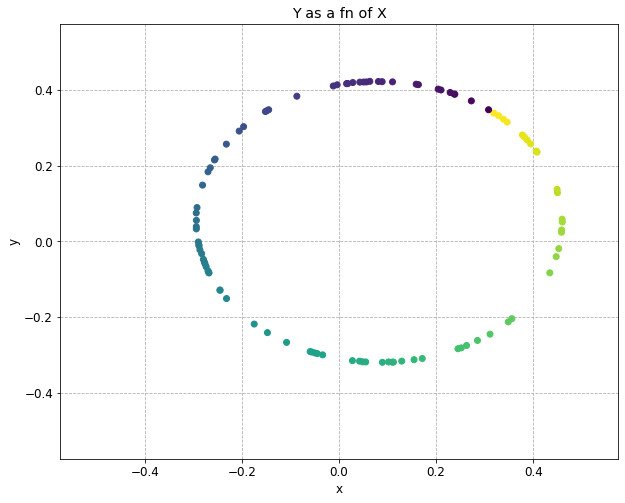

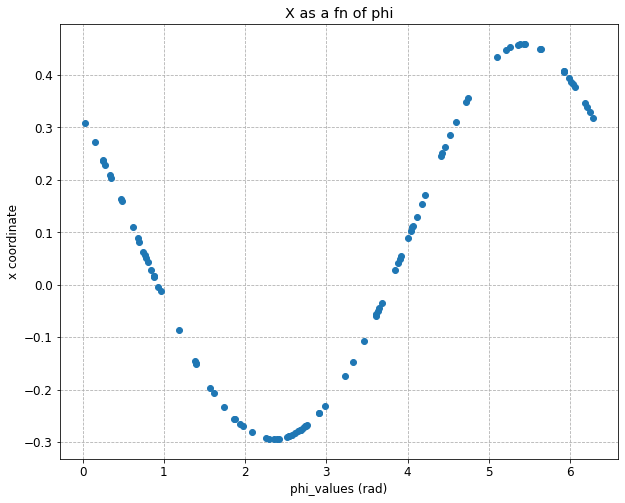

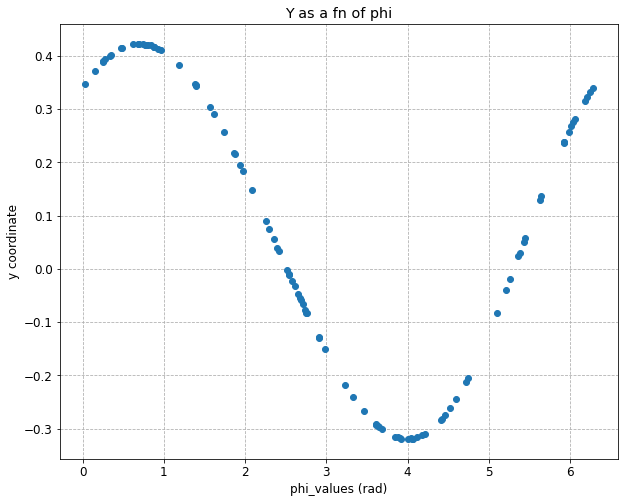

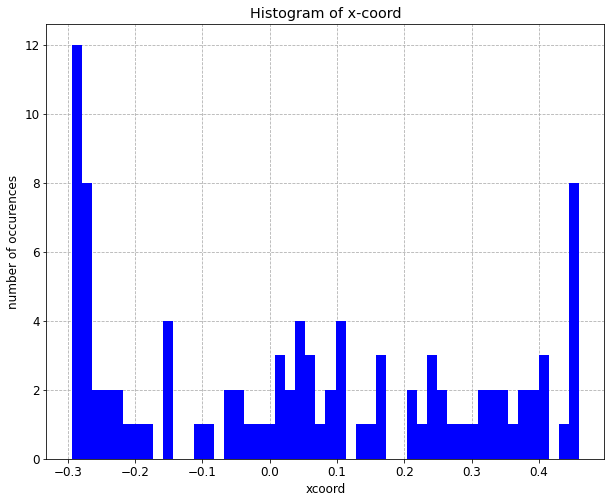

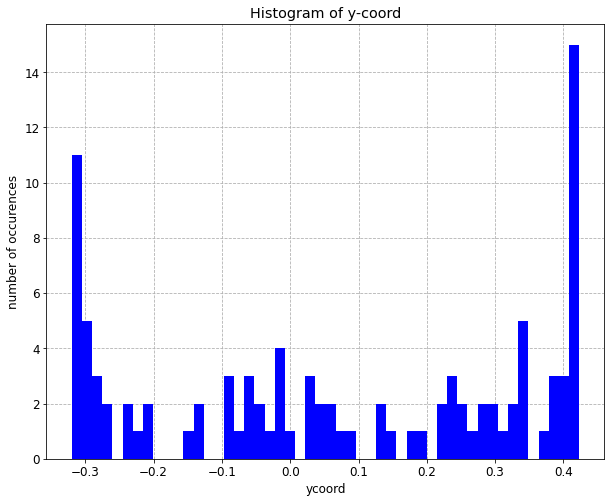

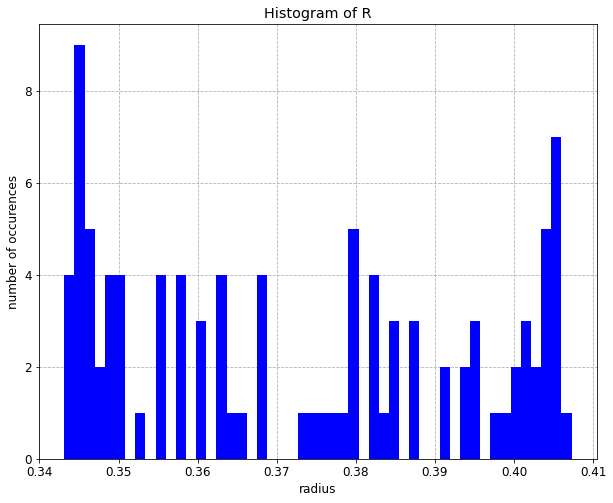

In [54]:
x = run(100, "run1/")
#np.save(x)

## Second Run Function (Graded Field)

In [61]:
def run2(N, output_directory):
    phis = get_random_phi(N)
    ts = []
    xs = []
    ys = []
    zs = []
    rs = []
    # for each phi, run create solver object and save trajectory object
    for phi in phis:
        dataframe = run_solver(phi, 4001, gradedBfunc, 0.054094482, 0.03873037, 5.988900879) #second argument is how many steps in numerical integration
        x, y, z, t, r = find_track_at_z(dataframe,13)
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        rs.append(r)
    # convert everything to numpy arrays
    ts = np.array(ts)
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    rs = np.array(rs)
    # plot results (and save plots)
    plot_impact_at_calorimeter(ts, phis, rs, xs, ys, zs, output_directory)
    return (ts, phis, rs, xs, ys, zs)
    

actual radius: 0.33724987514623306


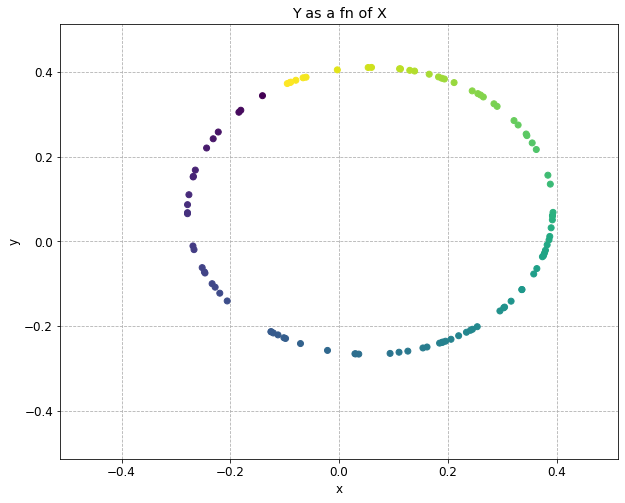

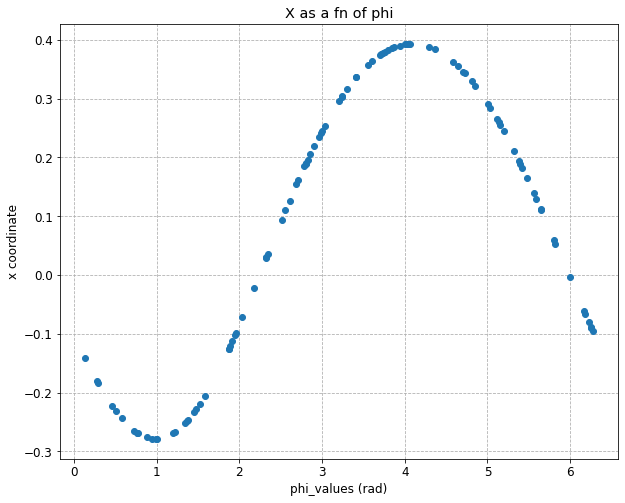

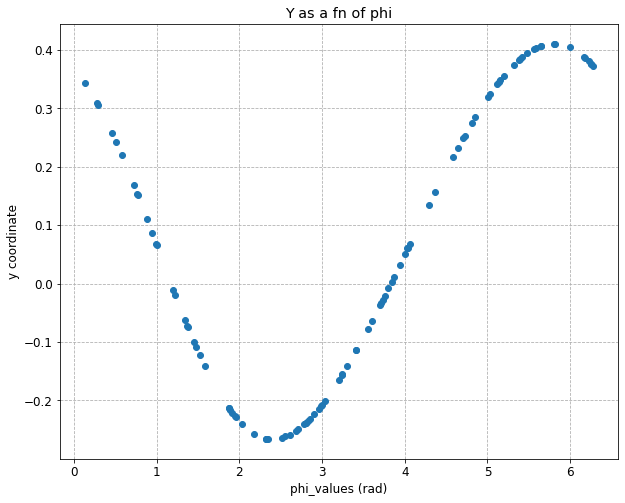

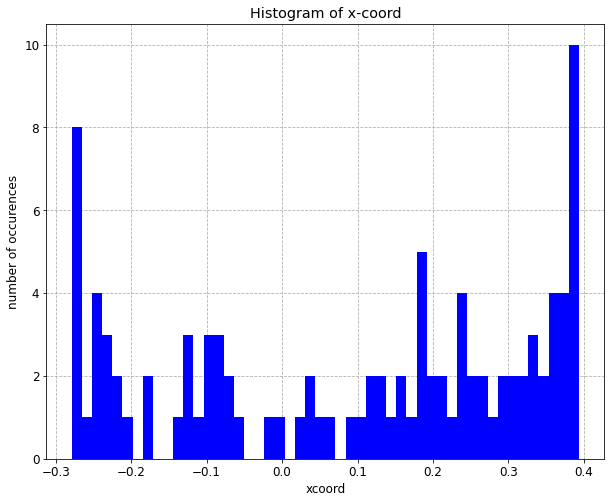

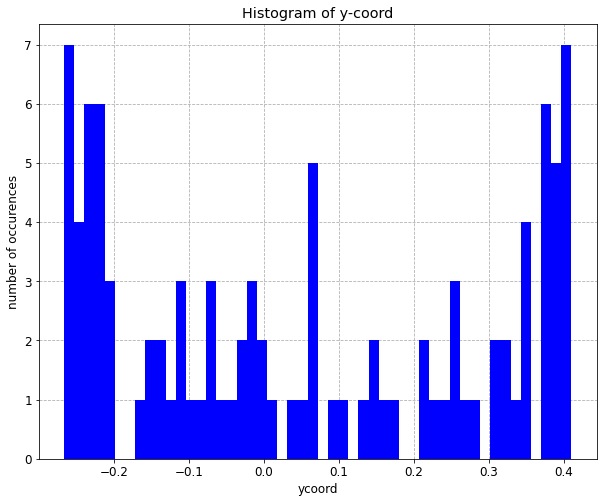

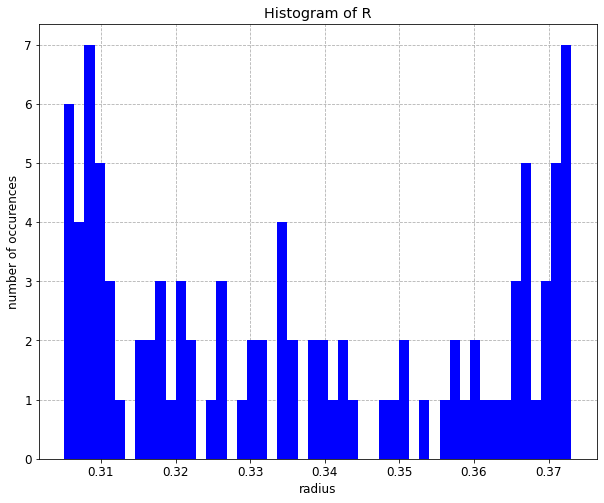

In [62]:
y = run2(100, 'run2/')

<bound method Figure.show of <Figure size 720x576 with 1 Axes>>

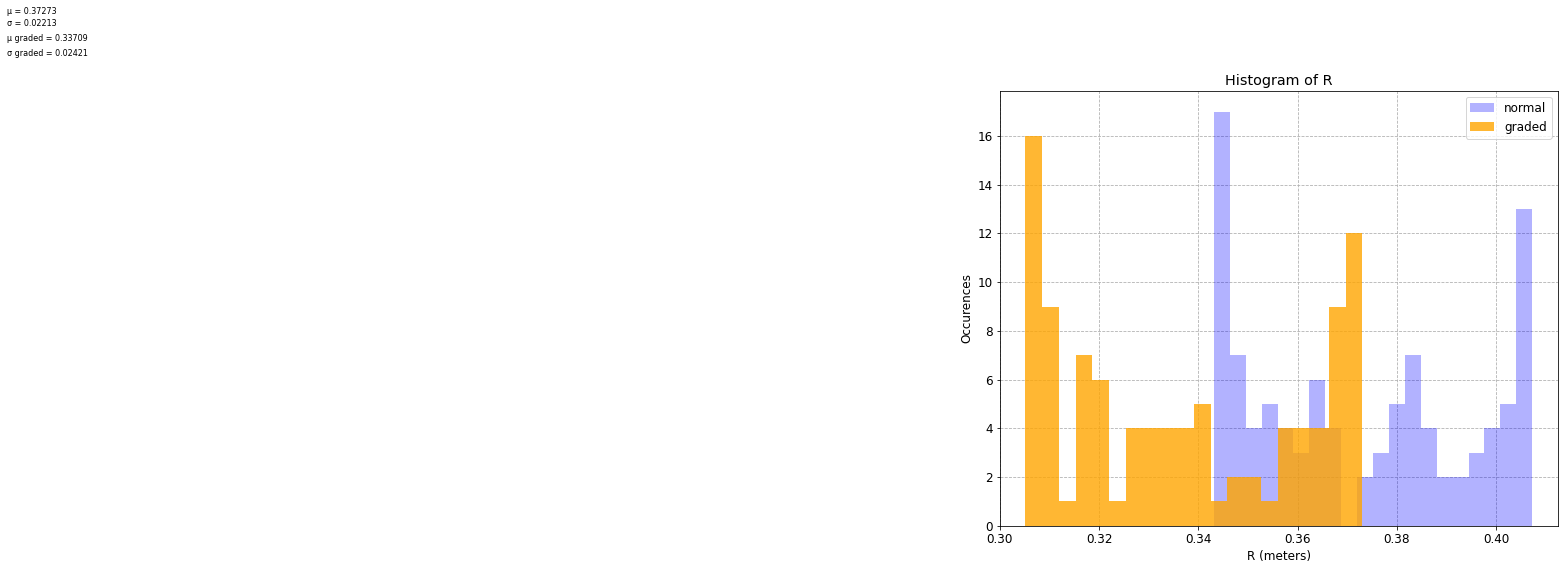

In [63]:
#x is regular, y is graded
x1, x2 = x[2], y[2]
num_bins = 20

m1 = np.mean(x1)
std1 = np.std(x1)
m2 = np.mean(x2)
std2 = np.std(x2)

fig = plt.figure()

plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue', label = 'normal')
plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange', label = 'graded')

plt.legend()
plt.legend()

plt.text(0.1, 21, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
plt.text(0.1, 20.5, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
plt.text(0.1, 19.9, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
plt.text(0.1, 19.3, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

plt.xlabel('R (meters)')
plt.ylabel('Occurences')
plt.title('Histogram of R')  
fig.show

<bound method Figure.show of <Figure size 720x576 with 1 Axes>>

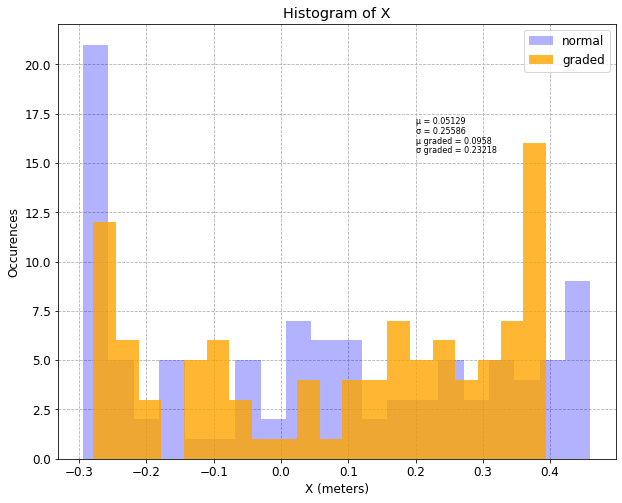

In [64]:
#x is regular, y is graded
x1, x2 = x[3], y[3]
num_bins = 20
m1 = np.mean(x1)
std1 = np.std(x1)
m2 = np.mean(x2)
std2 = np.std(x2)

fig = plt.figure()

plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

plt.legend()


plt.text(0.2, 17, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
plt.text(0.2, 16.5, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
plt.text(0.2, 16, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
plt.text(0.2, 15.5, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

plt.xlabel('X (meters)')
plt.ylabel('Occurences')
plt.title('Histogram of X')  
fig.show

<bound method Figure.show of <Figure size 720x576 with 1 Axes>>

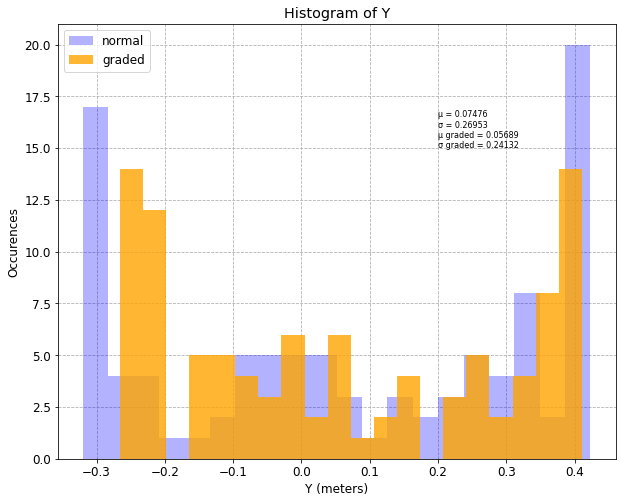

In [65]:
#x is regular, y is graded
x1, x2 = x[4], y[4]
num_bins = 20
m1 = np.mean(x1)
std1 = np.std(x1)
m2 = np.mean(x2)
std2 = np.std(x2)

fig = plt.figure()

plt.hist(x1, alpha = 0.3, bins = num_bins, facecolor='blue',  label = 'normal')
plt.hist(x2, alpha = 0.8, bins = num_bins, facecolor='orange',  label = 'graded')

plt.legend()

plt.text(0.2, 16.5, '\u03BC = '+str(round(np.mean(x1), 5)), fontsize = 8)
plt.text(0.2, 16, '\u03C3 = '+str(round(np.std(x1), 5)), fontsize = 8)
plt.text(0.2, 15.5, '\u03BC graded = '+str(round(np.mean(x2), 5)), fontsize = 8)
plt.text(0.2, 15, '\u03C3 graded = '+str(round(np.std(x2), 5)), fontsize = 8)

plt.xlabel('Y (meters)')
plt.ylabel('Occurences')
plt.title('Histogram of Y')  
fig.show